# Part 2: Illness Detection
### This part determines level of illness within sheep based on sitting/standing ground truth data

In [109]:
# Imports
import pandas as pd
import numpy as np
import statistics
from sklearn.preprocessing import StandardScaler

In [110]:
# read in the data first
# note that D is missing several days
files = ['A.csv', 'B.csv', 'U.csv', 'V.csv', 'W.csv', 'D.csv']
sheep_raw = []
data_dir = 'data/'
for file in files:
    file = data_dir + file
    df = pd.read_csv(file)
    # drop unnecessary columns
    df = df.drop(columns=df.columns[3:])
    df = df.drop(columns=df.columns[0:2])

    # rename column
    df.columns = ['Standing']

    # change accelerometer value to 1 if standing, 0 if sitting
    # THERE'S A SPECIAL CASE FOR SHEEP V, THE ACCELEROMETER WAS UPSIDE DOWN
    if file == 'V.csv':
        df['Standing'] = np.where(df['Standing'] > 0.49, 1, 0)
    else:
        df['Standing'] = np.where(df['Standing'] < -0.4, 1, 0)
    sheep_raw.append(df)

In [111]:
# version of reading in ALL data
all_files = ['A.csv', 'B.csv', 'C.csv', 'D.csv', 'E.csv', 'F.csv', 'G.csv', 'H.csv', 'I.csv', 'J.csv', 'K.csv', 'L.csv', 'M.csv', 'N.csv', 'O_0.csv', 'P.csv', 'Q.csv', 'R_0.csv', 'S.csv', 'T.csv', 'U.csv', 'V.csv', 'W.csv']

sheep_raw_full = []
data_dir = 'data/'
for file in files:
    file = data_dir + file
    df = pd.read_csv(file)
    # drop unnecessary columns
    df = df.drop(columns=df.columns[3:])
    df = df.drop(columns=df.columns[0:2])

    # rename column
    df.columns = ['Standing']

    # change accelerometer value to 1 if standing, 0 if sitting
    # THERE'S A SPECIAL CASE FOR SHEEP V, THE ACCELEROMETER WAS UPSIDE DOWN
    if file == 'V.csv':
        df['Standing'] = np.where(df['Standing'] > 0.49, 1, 0)
    else:
        df['Standing'] = np.where(df['Standing'] < -0.4, 1, 0)
    sheep_raw_full.append(df)

In [112]:
print(sheep_raw[0].shape)
print(sheep_raw[1].shape)
print(sheep_raw[2].shape)
print(sheep_raw[3].shape)
print(sheep_raw[4].shape)
print(sheep_raw[5].shape)

(21686, 1)
(21686, 1)
(21686, 1)
(21686, 1)
(21686, 1)
(5831, 1)


### Windowing

In [113]:
# Function to window our samples
def splitSamples(df: pd.DataFrame, samples_per_split: int) -> list:
    all_samples = []
    start_index = 0
    end_index = samples_per_split
    while end_index < len(df):
        temp_df = df[start_index:end_index]
        all_samples.append(temp_df)
        start_index += samples_per_split // 2
        end_index += samples_per_split // 2
    
    return all_samples

In [114]:
# Call the function with each dataframe to get sample lists

# The accelerometer records 2880 times a day, so let's try a window of that size
SAMPLES_PER_SPLIT = 2880
for i in range(len(sheep_raw)):
    sheep_raw[i] = splitSamples(sheep_raw[i], SAMPLES_PER_SPLIT)

for i in range(len(sheep_raw_full)):
    sheep_raw_full[i] = splitSamples(sheep_raw_full[i], SAMPLES_PER_SPLIT)


In [115]:
# Convert dataframes into just a list of sit/stand
for i in range(len(sheep_raw)):
    for j in range(len(sheep_raw[i])):
        sheep_raw[i][j] = sheep_raw[i][j]['Standing'].tolist()

# Convert dataframes into just a list of sit/stand
for i in range(len(sheep_raw_full)):
    for j in range(len(sheep_raw_full[i])):
        sheep_raw_full[i][j] = sheep_raw_full[i][j]['Standing'].tolist()

### Feature Engineering

In [116]:
def extractFeatures(windows: list) -> list:
    """
    There are a few features we should extract here
    1. total sits
    2. total stands
    3. changes (how many times did it go from sit to stand or vice versa)
    4. mean (essentially what percentage of the time was it standing)
    5. mode (was it standing or sitting more)
    6. longest sit
    7. longest stand
    8. Average length of sitting bouts
    9. Average length of standing bouts
    10. Std dev of sitting bouts
    11. Standard deviation of standing bouts
    """
    X = []

    for window in windows:
        temp = []
        total_sit = 0
        total_stand = 0
        total_changes = 0
        longest_sit = 0
        longest_stand = 0
        average_sit = []
        average_stand = []

        current_sit_streak = 0
        current_stand_streak = 0

        # mean and median can be calculated without looping
        mean = np.mean(window)
        mode = statistics.mode(window)

        prev_state = window[0]

        for sample in window:
            if sample == 0:
                total_sit += 1
                current_sit_streak += 1
                if current_sit_streak > longest_sit:
                    longest_sit = current_sit_streak
                if prev_state != sample:
                    total_changes += 1
                    average_stand.append(current_stand_streak)
                    current_stand_streak = 0
            else:
                total_stand += 1
                current_stand_streak += 1
                if current_stand_streak > longest_stand:
                    longest_stand = current_stand_streak
                if prev_state != sample:
                    total_changes += 1
                    average_sit.append(current_sit_streak)
                    current_sit_streak = 0
            
            # add on any leftover sits or stands
            if current_sit_streak != 0:
                average_sit.append(current_sit_streak)
            else:
                average_stand.append(current_stand_streak)

            # can't have empty lists
            if not average_sit:
                average_sit.append(0)
            if not average_stand:
                average_stand.append(0)
            prev_state = sample

        temp.append(total_sit)
        temp.append(total_stand)
        temp.append(total_changes)
        temp.append(mean)
        temp.append(mode)
        temp.append(longest_sit)
        temp.append(longest_stand)
        temp.append(np.mean(average_sit))
        temp.append(np.mean(average_stand))
        temp.append(np.std(average_sit))
        temp.append(np.std(average_stand))

        X.append(temp.copy())

    return X




In [117]:
sheep = []
for i in range(len(sheep_raw)):
    sheep.append(extractFeatures(sheep_raw[i]))

sheep_full = []
for i in range(len(sheep_raw_full)):
    sheep_full.append(extractFeatures(sheep_raw_full[i]))

In [118]:
print(sheep[0][0])
print(sheep[0][1])

print(sheep_full[0][0])
print(sheep_full[0][1])

[1999, 881, 118, 0.3059027777777778, 0, 175, 116, 62.21137026239067, 22.103081827842722, 42.75723646511831, 24.541816253464393]
[1885, 995, 114, 0.3454861111111111, 0, 198, 116, 58.02368692070031, 25.64577397910731, 43.31277351234201, 26.867492965424038]
[1999, 881, 118, 0.3059027777777778, 0, 175, 116, 62.21137026239067, 22.103081827842722, 42.75723646511831, 24.541816253464393]
[1885, 995, 114, 0.3454861111111111, 0, 198, 116, 58.02368692070031, 25.64577397910731, 43.31277351234201, 26.867492965424038]


### Create X and Y to prepare model

In [120]:
X = []
X_RAW = []
y = []

# Sheep have 5 levels of illness. We group these into 3 levels:
#   1 = not sick
#   2,3 = moderately sick
#   4,5 = very sick
# Sheep A, B, U, V, W, and D have sickness levels of 4, 3, 5, 1, 2, and 5 respectively
SHEEP_ILLNESS_LEVEL = [2, 1, 2, 0, 1, 2]
for s, sr, ill in zip(sheep, sheep_raw, SHEEP_ILLNESS_LEVEL):
    for window, window_raw in zip(s, sr):
        X.append(window)
        X_RAW.append(window_raw)
        y.append(ill)

X_FULL = []
X_RAW_FULL = []
y_full = []
# FULL_SHEEP_ILLNESS_LEVEL = [4, 3, 1, 5, 2, 1, 3, 5, 4, 1, 4, 4, 2, 2, 3, 3, 5, 3, 4, 1, 5, 1, 2]
FULL_SHEEP_ILLNESS_LEVEL = [2, 1, 0, 2, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1]
for s, sr, ill in zip(sheep_full, sheep_raw_full, FULL_SHEEP_ILLNESS_LEVEL):
    for window, window_raw in zip(s, sr):
        X_FULL.append(window)
        X_RAW_FULL.append(window_raw)
        y_full.append(ill)

# normalize X
sc = StandardScaler()
X = sc.fit_transform(X)
sc = StandardScaler()
X_FULL = sc.fit_transform(X_FULL)

### Model Creation

In [121]:
# Train and evaluate the model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_model(X, y, model):
    # Do the K-fold cross validation
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # This function sets an empty array of size len(y)
    # It then does the predictions for each fold (retraining the model each time)
    # and fills in the prediction in the correct spot in the array. By the end of it,
    # you will have your y array and a new array (predictions) of guesses for each sample
    # this is because Kfold uses each sample once for test data.
    predictions = cross_val_predict(model, X, y, cv=cv)

    # we can use this to create a confusion matrix
    new_labels = ['Not Sick', 'Moderately Sick', 'Very Sick']
    old_labels = [0, 1, 2]
    cm = confusion_matrix(y, predictions)
    plt.matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xticks(ticks=old_labels, labels=new_labels)
    plt.yticks(ticks=old_labels, labels=new_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Label')
    
    print(f'All accuracy scores from 10 folds:')
    for score in scores:
        print(f'{round(score * 100, 2)}%', end=' ')
    print()
    print(f'Mean Accuracy from 10 Fold Cross-Validation: {round(np.mean(scores)*100, 2)}%\n')

### Testing Models

USING RAW DATA
All accuracy scores from 10 folds:
62.5% 62.5% 62.5% 85.71% 71.43% 57.14% 71.43% 42.86% 57.14% 28.57% 
Mean Accuracy from 10 Fold Cross-Validation: 60.18%

*********************
USING FEATURE ENGINEERED DATA
All accuracy scores from 10 folds:
37.5% 37.5% 62.5% 71.43% 71.43% 57.14% 57.14% 71.43% 100.0% 85.71% 
Mean Accuracy from 10 Fold Cross-Validation: 65.18%

*********************
USING RAW DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
25.0% 37.5% 37.5% 42.86% 42.86% 57.14% 71.43% 71.43% 42.86% 42.86% 
Mean Accuracy from 10 Fold Cross-Validation: 47.14%

*********************
USING FEATURE ENGINEERED DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
75.0% 50.0% 50.0% 100.0% 85.71% 57.14% 57.14% 100.0% 100.0% 100.0% 
Mean Accuracy from 10 Fold Cross-Validation: 77.5%



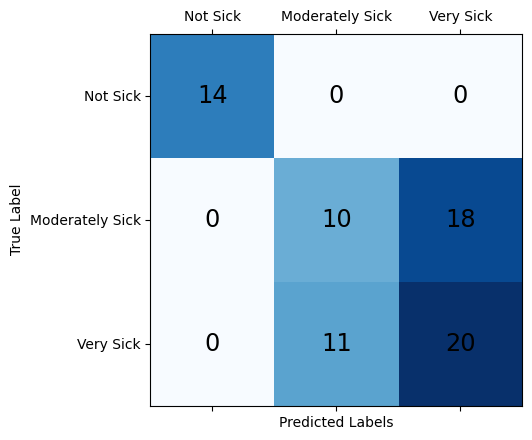

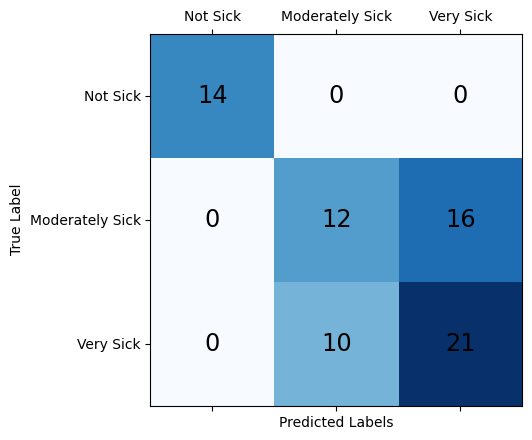

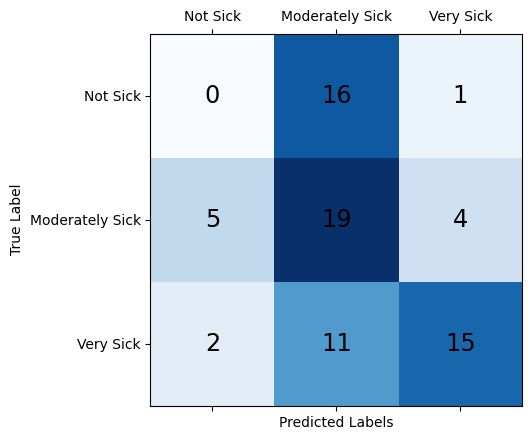

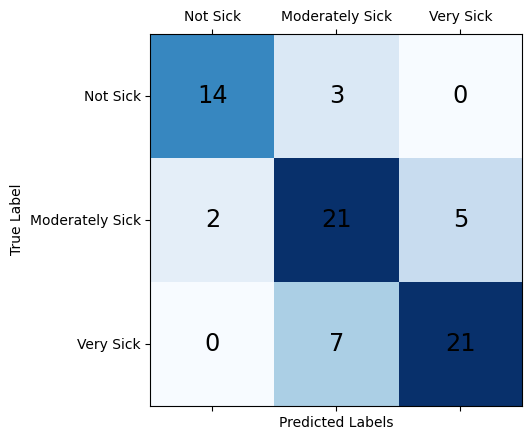

In [129]:
from sklearn.ensemble import RandomForestClassifier

print('USING RAW DATA')
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_RAW, y, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA')
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X, y, model)

print('*********************')
print('USING RAW DATA WITH ALL SHEEP')
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_RAW_FULL, y_full, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA WITH ALL SHEEP')
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_FULL, y_full, model)


USING RAW DATA
All accuracy scores from 10 folds:
37.5% 62.5% 62.5% 42.86% 57.14% 57.14% 71.43% 28.57% 57.14% 42.86% 
Mean Accuracy from 10 Fold Cross-Validation: 51.96%

*********************
USING FEATURE ENGINEERED DATA
All accuracy scores from 10 folds:
62.5% 50.0% 75.0% 71.43% 85.71% 85.71% 57.14% 57.14% 100.0% 71.43% 
Mean Accuracy from 10 Fold Cross-Validation: 71.61%

*********************
USING RAW DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
0.0% 25.0% 37.5% 57.14% 28.57% 71.43% 71.43% 57.14% 42.86% 28.57% 
Mean Accuracy from 10 Fold Cross-Validation: 41.96%

*********************
USING FEATURE ENGINEERED DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
62.5% 50.0% 50.0% 71.43% 85.71% 57.14% 71.43% 100.0% 85.71% 100.0% 
Mean Accuracy from 10 Fold Cross-Validation: 73.39%



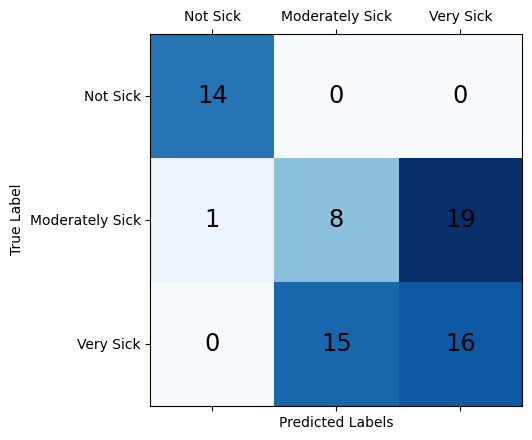

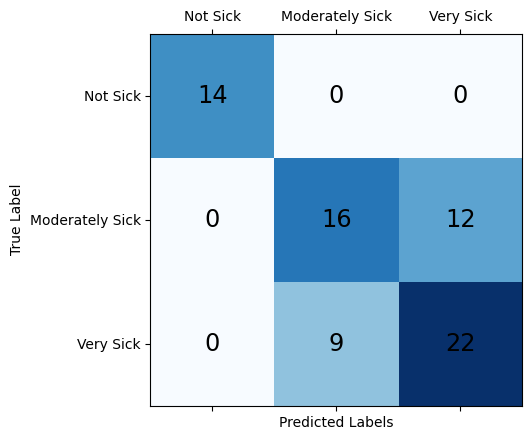

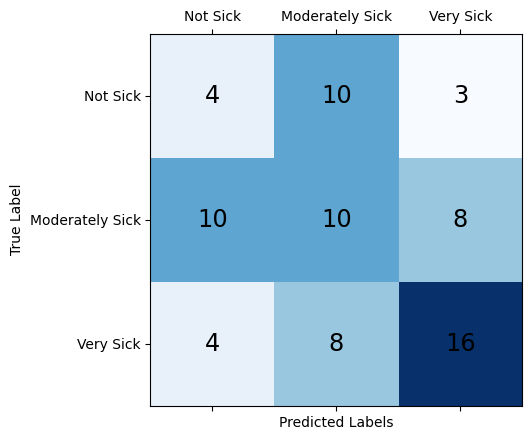

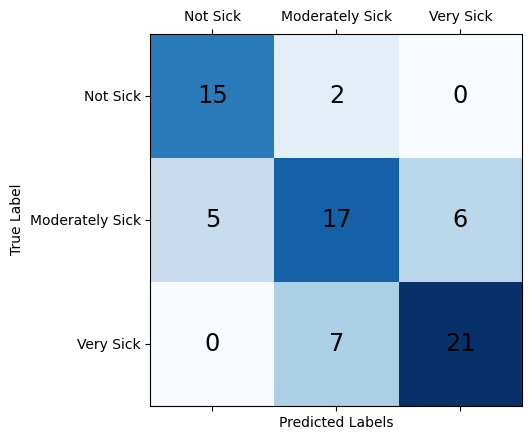

In [128]:
from xgboost import XGBClassifier

print('USING RAW DATA')
model = XGBClassifier()
train_and_evaluate_model(X_RAW, y, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA')
model = XGBClassifier()
train_and_evaluate_model(X, y, model)

print('*********************')
print('USING RAW DATA WITH ALL SHEEP')
model = XGBClassifier()
train_and_evaluate_model(X_RAW_FULL, y_full, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA WITH ALL SHEEP')
model = XGBClassifier()
train_and_evaluate_model(X_FULL, y_full, model)

USING RAW DATA
All accuracy scores from 10 folds:
62.5% 62.5% 62.5% 57.14% 57.14% 57.14% 42.86% 57.14% 57.14% 71.43% 
Mean Accuracy from 10 Fold Cross-Validation: 58.75%

*********************
USING FEATURE ENGINEERED DATA
All accuracy scores from 10 folds:
75.0% 62.5% 62.5% 57.14% 57.14% 57.14% 57.14% 57.14% 57.14% 71.43% 
Mean Accuracy from 10 Fold Cross-Validation: 61.43%

*********************
USING RAW DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
37.5% 37.5% 37.5% 42.86% 57.14% 85.71% 71.43% 71.43% 71.43% 71.43% 
Mean Accuracy from 10 Fold Cross-Validation: 58.39%

*********************
USING FEATURE ENGINEERED DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
25.0% 37.5% 37.5% 42.86% 57.14% 57.14% 57.14% 71.43% 71.43% 71.43% 
Mean Accuracy from 10 Fold Cross-Validation: 52.86%



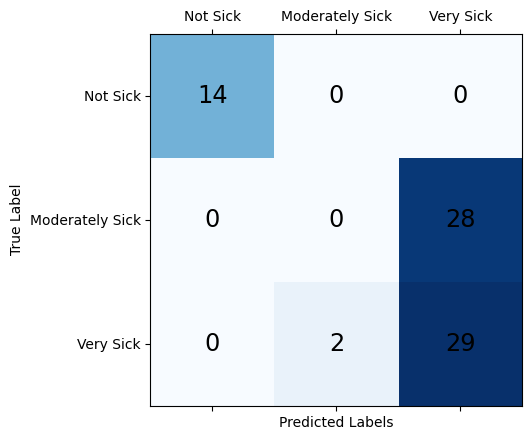

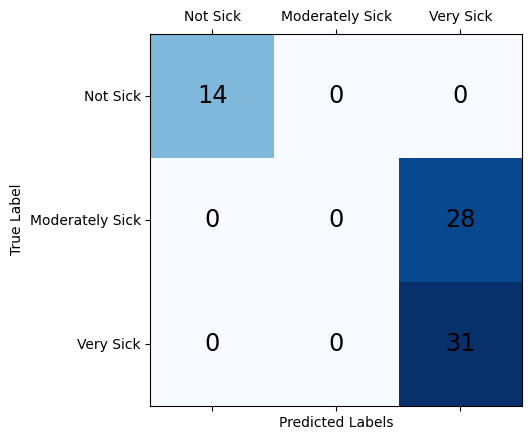

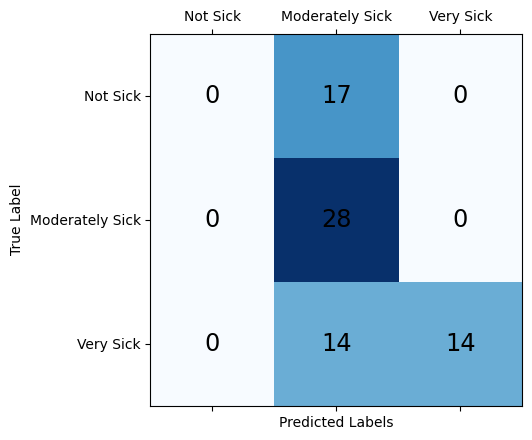

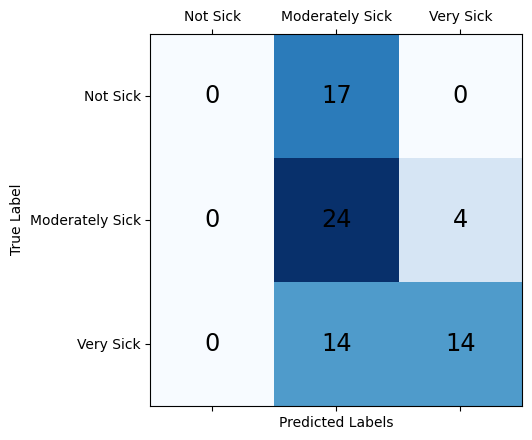

In [127]:
from sklearn.svm import SVC

print('USING RAW DATA')
model = SVC()
train_and_evaluate_model(X_RAW, y, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA')
model = SVC()
train_and_evaluate_model(X, y, model)

print('*********************')
print('USING RAW DATA WITH ALL SHEEP')
model = SVC()
train_and_evaluate_model(X_RAW_FULL, y_full, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA WITH ALL SHEEP')
model = SVC()
train_and_evaluate_model(X_FULL, y_full, model)

USING RAW DATA
All accuracy scores from 10 folds:
62.5% 75.0% 62.5% 71.43% 57.14% 28.57% 28.57% 85.71% 57.14% 42.86% 
Mean Accuracy from 10 Fold Cross-Validation: 57.14%

*********************
USING FEATURE ENGINEERED DATA
All accuracy scores from 10 folds:
62.5% 37.5% 37.5% 57.14% 71.43% 57.14% 42.86% 85.71% 57.14% 42.86% 
Mean Accuracy from 10 Fold Cross-Validation: 55.18%

*********************
USING RAW DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
25.0% 25.0% 37.5% 71.43% 42.86% 42.86% 71.43% 57.14% 71.43% 28.57% 
Mean Accuracy from 10 Fold Cross-Validation: 47.32%

*********************
USING FEATURE ENGINEERED DATA WITH ALL SHEEP
All accuracy scores from 10 folds:
12.5% 62.5% 75.0% 28.57% 71.43% 71.43% 57.14% 85.71% 100.0% 57.14% 
Mean Accuracy from 10 Fold Cross-Validation: 62.14%



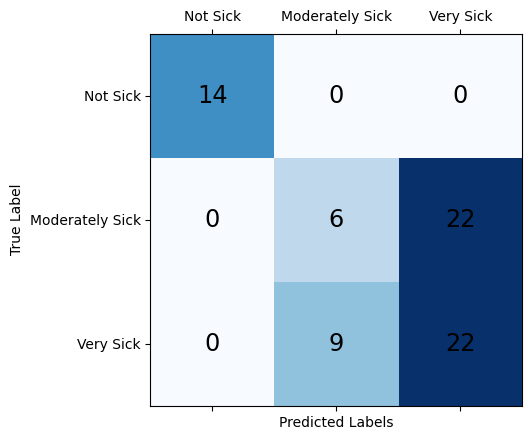

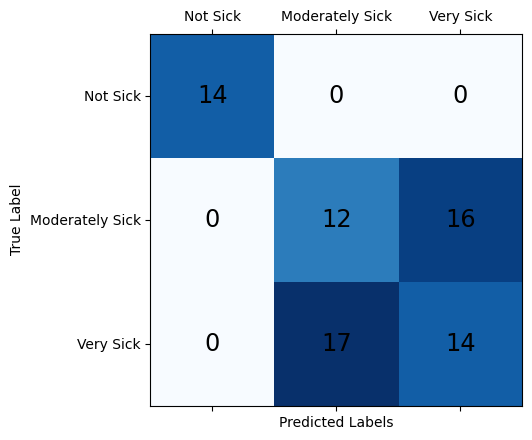

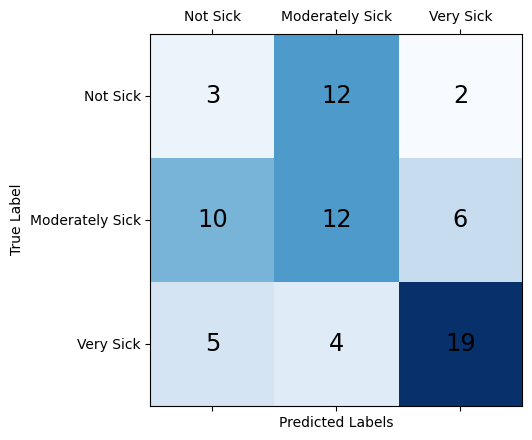

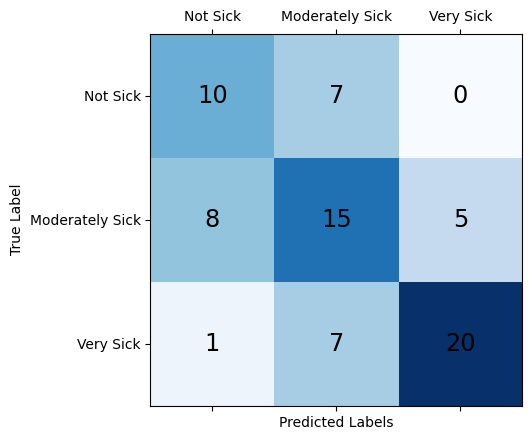

In [125]:
from sklearn.neighbors import KNeighborsClassifier

print('USING RAW DATA')
model = KNeighborsClassifier()
train_and_evaluate_model(X_RAW, y, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA')
model = KNeighborsClassifier()
train_and_evaluate_model(X, y, model)

print('*********************')
print('USING RAW DATA WITH ALL SHEEP')
model = KNeighborsClassifier()
train_and_evaluate_model(X_RAW_FULL, y_full, model)

print('*********************')
print('USING FEATURE ENGINEERED DATA WITH ALL SHEEP')
model = KNeighborsClassifier()
train_and_evaluate_model(X_FULL, y_full, model)